In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings
warnings.filterwarnings('ignore')


#### 1.0 Funciones útiles

In [3]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  count_values.index = count_values.index.astype('str') + pref
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])
  

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [4]:
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')
# data_vh = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
# data_le = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
# data_lv = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')

### 1.1.2 Transformación

#### 1.1.2.1 Dataset HM

##### 1.1.2.1.1 Análisis de Nulos

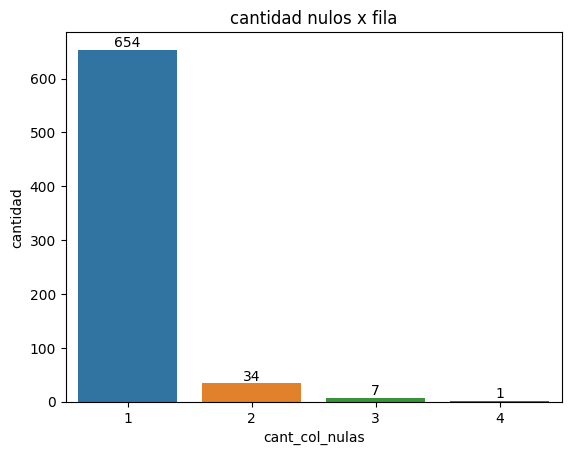

In [5]:
# Devuelve la cantidad filas que tienen la por cantidad de columnas nulas, es decir, 
# hay 88.310 filas que tienen 13 valores nulos, hay 22.530 filas que tienen 0 valores nulos

ax = sns.barplot(x=nulos_filas(data_hm).cant_col_nulas, y=nulos_filas(data_hm).cantidad)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("cantidad nulos x fila")
plt.show()

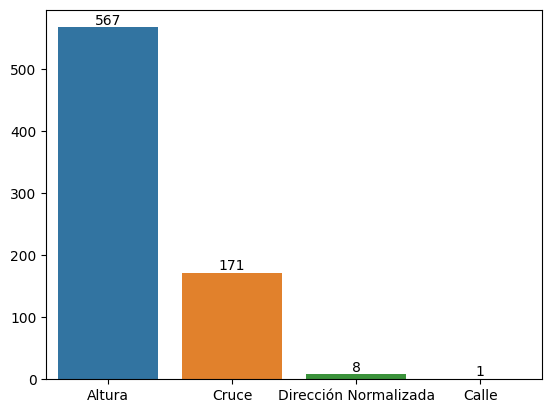

In [6]:
nulos_columnas = data_hm.isna().sum()[data_hm.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [7]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo
len(data_hm), len(data_hm.isna().T.sum())

(696, 696)

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [8]:
data_hm.Altura = data_hm.Altura.fillna('ESQ')
data_hm.Altura = data_hm.Altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [9]:
data_hm.Cruce = data_hm.Cruce.fillna('NA')

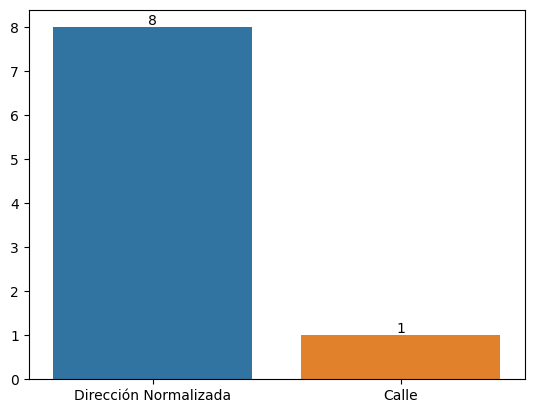

In [10]:
# data_sin_altura_cruce = data_hm[data_hm.columns[~data_hm.columns.isin(['Cruce', 'Altura'])]]
nulos_columnas = data_hm.isna().sum()[data_hm.isna().sum() > 0].sort_values(ascending=False)
if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [11]:
data_hm[data_hm.isna().iloc[:, 13]].head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,ESQ,NA,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,ESQ,NA,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


In [12]:
data_hm[data_hm.isna().iloc[:, 10]]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Al no tener información suficiente podemos excluir el registro ```2016-0151```. Falleció un peatón, sé a qué fecha-hora, pero no sé en dónde, ni cómo.

In [13]:
data_hm = data_hm.drop(data_hm[data_hm['ID']=='2016-0151'].index)

In [14]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_hm['Dirección Normalizada'].iloc[i] = data_hm['LUGAR_DEL_HECHO'].iloc[i]

Según lo visto, cuando la direcciòn normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

In [15]:
# data_['pos x'].apply(lambda x: float(x) if x.lstrip().isnumeric() else None)
data_hm['pos x'] = data_hm['pos x'].apply(lambda x: np.nan if x == '.' else float(x))
data_hm['pos y'] = data_hm['pos y'].apply(lambda x: np.nan if x == '.' else float(x))


In [16]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     695 non-null    object        
 1   N_VICTIMAS             695 non-null    int64         
 2   FECHA                  695 non-null    datetime64[ns]
 3   AAAA                   695 non-null    int64         
 4   MM                     695 non-null    int64         
 5   DD                     695 non-null    int64         
 6   HORA                   695 non-null    object        
 7   HH                     695 non-null    object        
 8   LUGAR_DEL_HECHO        695 non-null    object        
 9   TIPO_DE_CALLE          695 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 695 non-null    object        
 12  Cruce                  695 non-null    object        
 13  Dirección 

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [17]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [18]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [19]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')

In [20]:
data_hm["HORA"] = data_hm["HORA"].astype(str)

In [21]:
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)


In [22]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO


In [23]:
data_hm['COMUNA'] = data_hm['COMUNA'].replace('0', np.nan)

data_hm.query("index > 438")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
439,2019-0022,1,2019-03-15,00:00:00,ENTRE RIOS AV. BAJO PUENTE AUTOPISTA (1260 APROX),AVENIDA,ENTRE RIOS AV.,1260,NA,ENTRE RIOS AV. 1260,1,-58.391238,-34.623522,AUTO-SD,AUTO,SD
440,2019-0023,1,2019-03-16,08:28:00,"PAZ, GRAL. AV. Y JACQUES, AMADEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,"JACQUES, AMADEO","PAZ, GRAL. AV. y JACQUES, AMADEO",9,-58.529228,-34.636380,AUTO-OBJETO FIJO,AUTO,OBJETO FIJO
441,2019-0024,1,2019-03-19,07:12:00,ANTARTIDA ARGENTINA AV. 1325,AVENIDA,ANTARTIDA ARGENTINA AV.,1325,NA,ANTARTIDA ARGENTINA AV. 1325,1,-58.372081,-34.585420,MOTO-CARGAS,MOTO,CARGAS
442,2019-0025,1,2019-03-22,13:10:00,"MITRE, BARTOLOME Y SANCHEZ DE BUSTAMANTE",CALLE,"MITRE, BARTOLOME",ESQ,SANCHEZ DE BUSTAMANTE,"MITRE, BARTOLOME y SANCHEZ DE BUSTAMANTE",5,-58.414585,-34.609376,PEATON-AUTO,PEATON,AUTO
443,2019-0026,1,2019-03-28,07:32:00,"FERNANDEZ DE LA CRUZ, F. , GRAL. AV. Y LARRAZABAL",AVENIDA,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",ESQ,"PAZ, GRAL. AV.","FERNANDEZ DE LA CRUZ, F., GRAL. AV. y PAZ, GRA...",8,-58.479768,-34.691532,PEATON-PASAJEROS,PEATON,PASAJEROS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO
692,2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO
693,2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS
694,2021-0096,1,2021-12-15,10:30:00,AV. EVA PERON 4071,AVENIDA,"PERON, EVA AV.",4071,NA,"PERON, EVA AV. 4071",9,-58.470668,-34.650217,AUTO-CARGAS,AUTO,CARGAS


In [24]:
# data_hm['FECHA_HORA'] = pd.to_datetime(data_hm['FECHA']) + data_hm['HORA'].apply(lambda x: pd.Timedelta(x))

In [25]:
data_hm['HORA'] = data_hm['HORA'].astype(str)

In [26]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))

# data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: x.split(' ').split('-').split(':'))


In [27]:
data_hm['FECHA_HORA']

0      [2016, 01, 01, 04, 00, 00]
1      [2016, 01, 02, 01, 15, 00]
2      [2016, 01, 03, 07, 00, 00]
3      [2016, 01, 10, 00, 00, 00]
4      [2016, 01, 21, 05, 20, 00]
                  ...            
691    [2021, 12, 13, 17, 10, 00]
692    [2021, 12, 20, 01, 10, 00]
693    [2021, 12, 30, 00, 43, 00]
694    [2021, 12, 15, 10, 30, 00]
695    [2021, 11, 18, 06, 10, 00]
Name: FECHA_HORA, Length: 695, dtype: object

In [28]:
from datetime import datetime
# data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))
data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda t: datetime(* list(map(int, t))))

In [29]:
data_hm['FECHA_HORA'] 

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 695, dtype: datetime64[ns]

In [30]:

# year = int(data_hm['FECHA_HORA'][0][0])
# month = int(data_hm['FECHA_HORA'][0][1])
# day = int(data_hm['FECHA_HORA'][0][2])
# hour = int(data_hm['FECHA_HORA'][0][3])
# minutes = int(data_hm['FECHA_HORA'][0][4])
# seconds = int(data_hm['FECHA_HORA'][0][5])

# # Create datetime object
# dt = datetime(year, month, day, hour, minutes, seconds)

# # Convert to Pandas datetime
# pd.to_datetime(dt)


In [31]:
# year, month, day, hour, minute, second = map(int, data_hm['FECHA_HORA'][0])
# pd.to_datetime(datetime(year, month, day, hour, minute, second))

In [32]:
def to_timestamp(x):
    year, month, day, hour, minute, second = map(int, x)
    return datetime(year, month, day, hour, minute, second)

In [33]:
# to_timestamp(data_hm['FECHA_HORA'][0])

In [34]:
# data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)

In [35]:
# for i in data_hm['FECHA_HORA'].index:
#     try:
#         to_timestamp(data_hm['FECHA_HORA'].loc[i])
#     except:
#         print(data_hm[['FECHA', 'HORA']].loc[i])


In [36]:
# date_time_list = [int(x) for x in data_hm['FECHA_HORA'][0]]
# date_time_list

In [37]:
# year, month, day, hour, minutes, seconds 

In [38]:
data_hm.COMUNA.value_counts()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
Name: count, dtype: int64

In [39]:
type(data_hm['PARTICIPANTES'][0])

str

In [40]:
import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [41]:
data_hm['pos x'].mean()

-58.441545233561044

In [42]:
data_hm['pos y'].mean()

-34.61963157034328

In [43]:
# data_hm.groupby(['AAAA','COMUNA']).sum(['N_VICTIMAS'])

In [44]:
# data_['Dirección Normalizada'][data_['Dirección Normalizada'].isna()] = data_['LUGAR_DEL_HECHO'][data_['Dirección Normalizada'].isna()].copy()

In [45]:
data_hm['Dirección Normalizada'].isna().sum()

0

In [46]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [47]:
data_hm['Dirección Normalizada'].fillna(data_hm['LUGAR_DEL_HECHO'], inplace=True)


In [48]:
data_hm['Altura'].fillna('esq', inplace=True)

In [49]:
data_hm['Altura'].fillna('NA', inplace=True)

In [50]:
data_hm['Dirección Normalizada'].value_counts()

Dirección Normalizada
27 DE FEBRERO AV. y ESCALADA AV.                         5
PAZ, GRAL. AV. y BALBIN, RICARDO, DR. AV.                4
PAZ, GRAL. AV. y DEL LIBERTADOR AV.                      4
PAZ, GRAL. AV. y DE LOS CORRALES AV.                     3
CASTILLO, RAMON S., PRES. AV. y CALLE 12 (NO OFICIAL)    3
                                                        ..
GALLO y CORDOBA AV.                                      1
ARANGUREN, JUAN F., DR. 611                              1
AUTOPISTA PERITO MORENO y AUTOPISTA 25 DE MAYO           1
CHORROARIN y SAN MARTIN AV.                              1
PADRE CARLOS MUGICA 709                                  1
Name: count, Length: 642, dtype: int64

In [51]:
data_hm[data_hm['Calle'].isna()]

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,FECHA_HORA


In [52]:
data_hm['Dirección Normalizada'].isna().sum()

0

In [53]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 695
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     695 non-null    object        
 1   N_VICTIMAS             695 non-null    int64         
 2   FECHA                  695 non-null    datetime64[ns]
 3   HORA                   695 non-null    object        
 4   LUGAR_DEL_HECHO        695 non-null    object        
 5   TIPO_DE_CALLE          695 non-null    object        
 6   Calle                  695 non-null    object        
 7   Altura                 695 non-null    object        
 8   Cruce                  695 non-null    object        
 9   Dirección Normalizada  695 non-null    object        
 10  COMUNA                 694 non-null    object        
 11  pos x                  684 non-null    float64       
 12  pos y                  684 non-null    float64       
 13  PARTICIPAN

In [54]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [55]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,FECHA_HORA
ID,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,2021-12-30 00:43:00


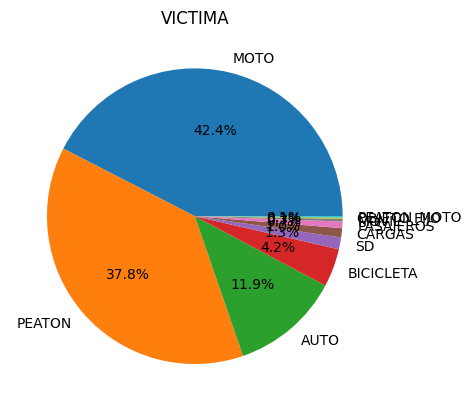

In [56]:
showPie(data['VICTIMA'])

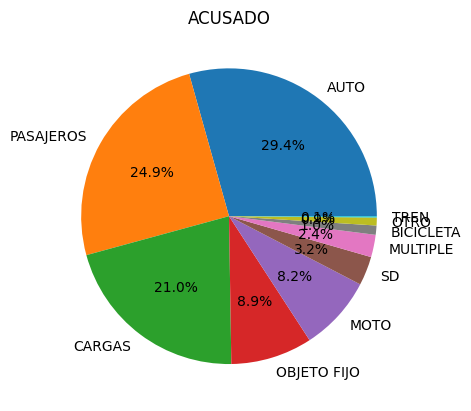

In [57]:
showPie(data['ACUSADO'])

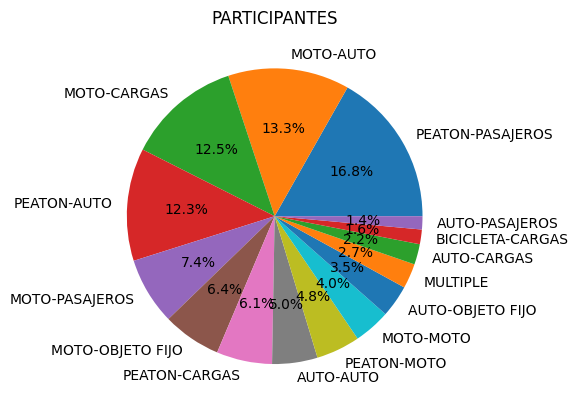

In [58]:
showPie(data['PARTICIPANTES'])

In [59]:
data.describe()

,N_VICTIMAS,FECHA,pos x,pos y,FECHA_HORA
count,695.000000,695,684.000000,684.000000,695
mean,1.030216,2018-09-15 04:10:42.302158336,-58.441545,-34.619632,2018-09-15 16:10:17.765467648
min,1.000000,2016-01-01 00:00:00,-58.529942,-34.705250,2016-01-01 04:00:00
25%,1.000000,2017-04-03 00:00:00,-58.476218,-34.643689,2017-04-03 16:27:30
50%,1.000000,2018-07-14 00:00:00,-58.444513,-34.622928,2018-07-14 06:04:00
75%,1.000000,2020-01-04 12:00:00,-58.401841,-34.596799,2020-01-05 03:20:00
max,3.000000,2021-12-30 00:00:00,-58.356082,-34.534654,2021-12-30 00:43:00
std,0.179519,NaN,0.046144,0.035289,NaN


In [60]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [61]:
barrios = pd.read_excel('data/barrios.xlsx')
len(barrios.dropna().BARRIO.unique())

48

In [62]:
comunas = pd.read_excel('data/comunas.xlsx')

comunas['barrios'] = comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
comunas.set_index('COMUNAS', drop=True, inplace=True)
comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [63]:
pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [64]:
barrio_comuna = pd.DataFrame(comunas.barrios.explode())

In [65]:
comunas

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
10,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."
11,LIMITE COMUNAL,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,"[VILLA DEL PARQUE, VILLA DEVOTO, VILLA GRAL. ..."
12,LIMITE COMUNAL,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,"[COGHLAN, SAAVEDRA, VILLA PUEYRREDON, VILLA UR..."
14,LIMITE COMUNAL,PALERMO,22126.531858,1.584587e+07,[PALERMO]


In [66]:
# barrios.BARRIO.

In [67]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [68]:
from ydata_profiling import profile_report

# profile_report.ProfileReport(data_hm)

In [69]:
# %pip install ipywidgets

In [70]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [71]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [72]:
data_hm['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    170
Name: count, dtype: int64

In [73]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [74]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    170
True     525
dtype: int64

In [75]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

TypeError: 'value' must be an instance of str or bytes, not a tuple

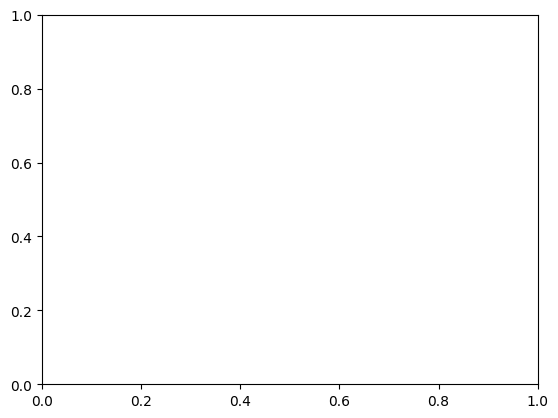

In [76]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

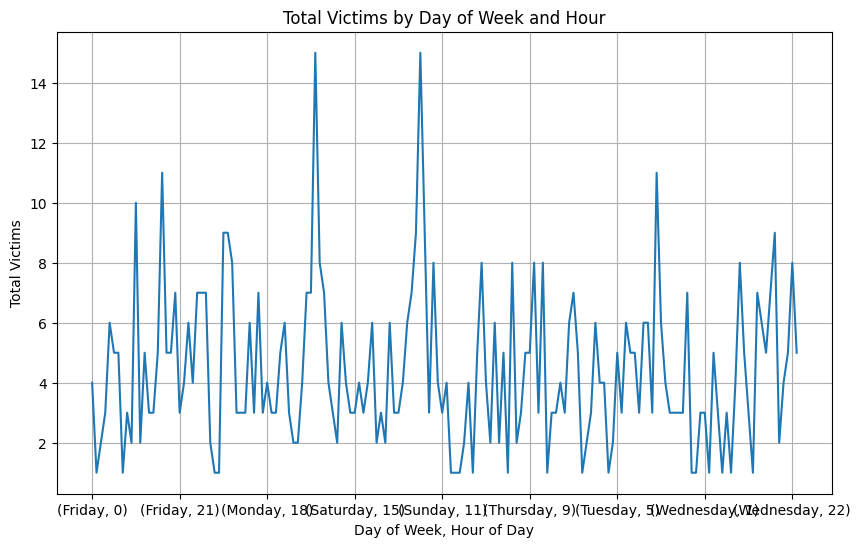

In [77]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [78]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [79]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [ ]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [80]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [81]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0      Calle
1    Esquina
Name: es_cruce, dtype: object

In [82]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0    Calle         176
1  Esquina         540


In [83]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

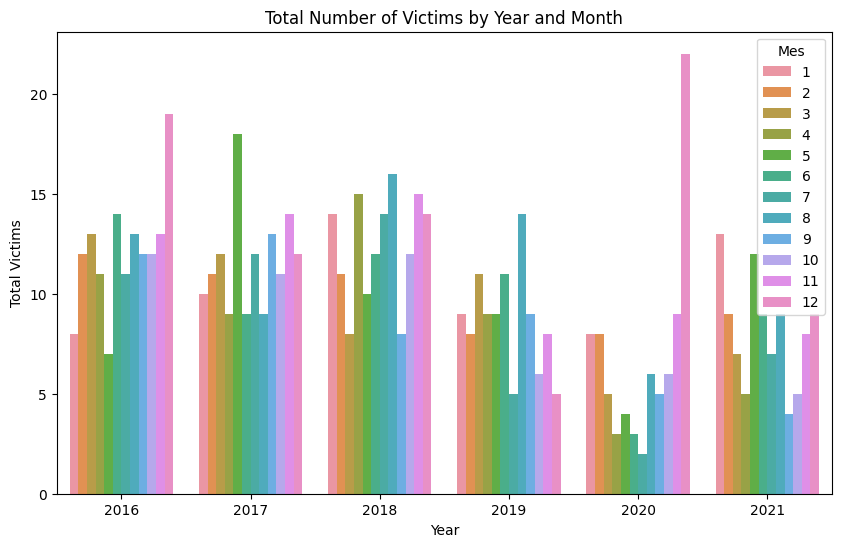

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [85]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [89]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [88]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 695, dtype: period[M]

In [94]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()
